# Data

* khu vực ven biển đảo chính Đài Loan phía Tây Thái Bình Dương: **tọa độ: 120°58'Đ $\rightarrow$ 122°06'Đ và 21°53' $\rightarrow$ 26°23'**
* Label: **phương pháp ngưỡng Otsu** + **Kiểm tra, xử lý thủ công**
* Bộ Quy hoạch và xây dựng (**CPAMI**) sử dụng thiết bị GPS trong khảo sát thực địa và vẽ 2 lần/năm (Được sử dụng để so sánh)

##  Sentinel-1 Data and Preprocessing

**Sentinel-1:**
* Là hệ thống gồm 2 vệ tinh radar -1A và -1B, tần suất ghé thăm 12 ngày
* Ảnh được sử dụng chiều rộng quét **250km** với **1pixel ~ 10m x10m**
* Từ năm **2016-2020**

**Tiền xử lý**: bằng app **SNAP**:
* Cập nhật tệp quỹ đạo
* Hiệu chỉnh bức xạ
* Hiệu chỉnh hình học
* Bộ **Lee filter** để remove noise

* **bóng radar** gây ảnh hưởng đến hình ảnh:
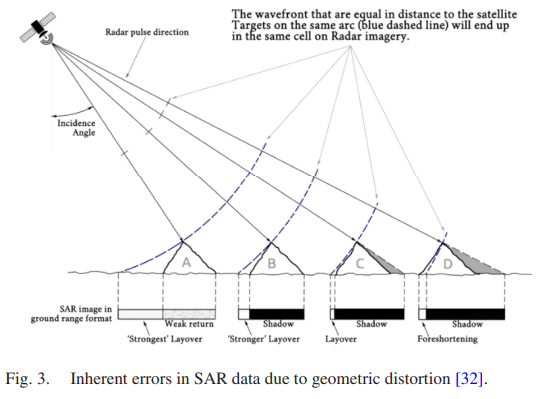

## DEM

* Cung cấp dữ liệu **độ cao địa hình** 

> Làm giảm hiệu ứng bóng radar

* Do tính tán xạ ngược của ảnh SAR, **phân cực VH** của **Sentinel-1** phù hợp hơn so với **phân cực VV**

> Kết hợp **Phân cực VH** của **Sentinel-1** với **DEM** cho **U-Net**

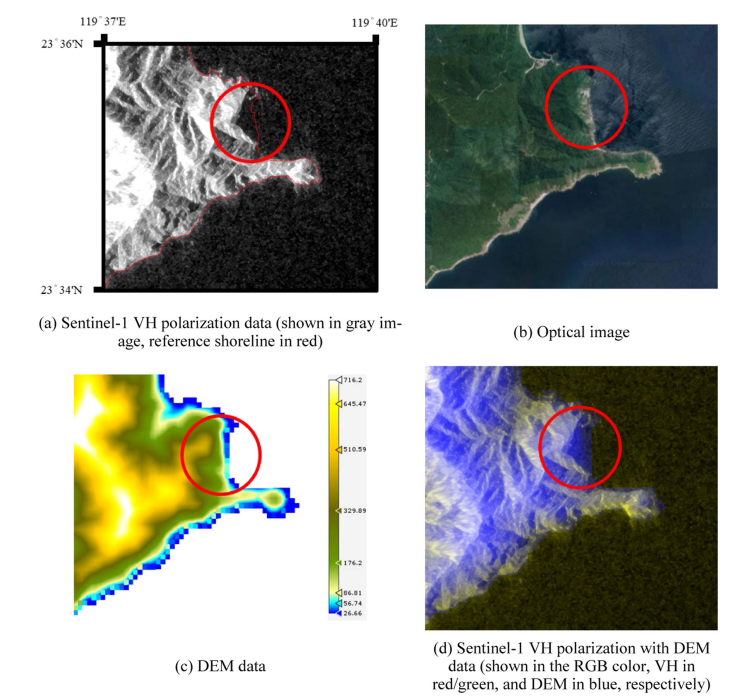

# Approach

## Modified U-Net

*Standard U-Net*

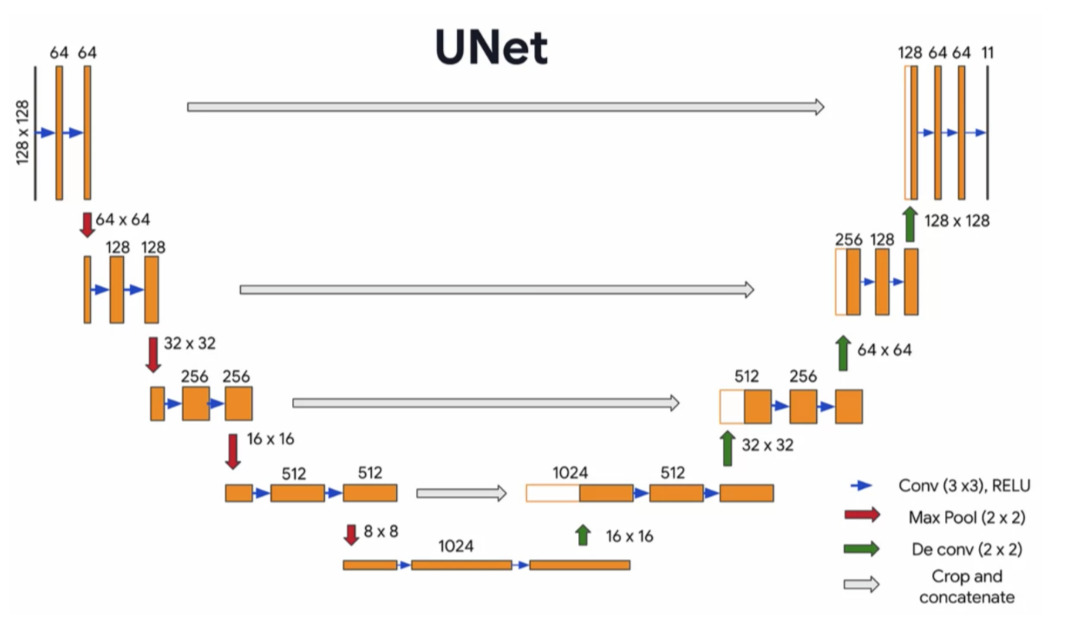

* 📉  **Encoder** (Downsampling path):
    * Các **khối convolution 3x3 + Bacth Norm + ReLU activation**
    * Sau các khối conv dùng **max-pooling 2x2** để giảm kích thước không gian, tăng số lượng kênh feature 
* 📊 **Bottleneck**:
    * Lớp sâu nhất mạng, chứa các **convolution layers** nhằm học các đặc trưng trừu tượng hơn
* 📈 **Decoder** (Upsampling path):
    * Sử dụng **transposed convolution** (deconvolution) để tăng kích thước đặc trưng
    * **Skip connections** từ encoder để phục hồi thông tin
* ✅ **Output**: 
    * **Convolution 1x1** với activation **sigmoid** để tạo probability map cho mỗi pixel

*Modified U-Net*

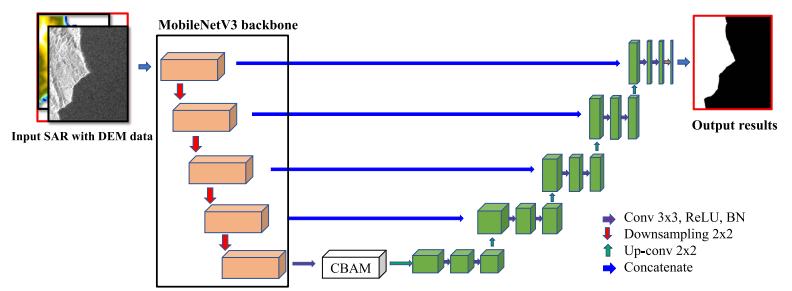

(?) **Batch Norm được đặt sau ReLU????**:  
> The decoder part consisted of a 2 × 2 transposed convolution
unit, which was concatenated with the previous encoder output, and then fed the result into **two convolution blocks consisting of a 3 × 3 convolutional layer followed by an activation ReLU and a BN layer**

**Architecture**:
* 📉  **Encoder**: <span style="color: red;">**MobileNetV3 Backbone**</span>:
    * Giảm đáng kể tham số và tài nguyên tính toán cho mô hình
    * Dựa trên <span style="color: red;">**Inverted Residual Blocks** </span>với thành phần chính:
        * **Depwise Separable Convolution**: Tách convolution theo chiều sâu.
        * **Linear Bottleneck**
        * **Squeeze-and-Excitation**: cơ chế nén thông tin, tăng cường thông tin quan trọng bằng cách tạo trọng số học cho từng kênh.
        * **Hard Swish Activation**: cải thiện hạn chế của **ReLU**: (Gradient không liên tục, Dying ReLU)
* 📊 **Bottleneck**:
    * Lớp sâu nhất mạng, chứa <span style="color: red;">**Linear Bottleneck**</span>
    * <span style="color: red;">**CBAM**</span>
 được tích hợp để tăng cường học đặc trưng quan trọng:
        * **Channel Attention Module**: Xác định mức độ quan trọng của từng kênh đặc trưng bằng **Global Average Pooling (GAP)** và **Global Max Pooling (GMP)**
        * **Spatial Attention MOdule**: tính toán bản đồ trọng số không gian, chú ý vào các vùng quan trọng trong không gian
* 📈 **Decoder** (Upsampling path): Giữ nguyên
    * **Transposed convolution** (deconvolution) để tăng kích thước đặc trưng
    * **Skip connections**
* ✅ **Output**: 
    * **Convolution 1x1** với activation **sigmoid** để tạo probability map cho mỗi pixel

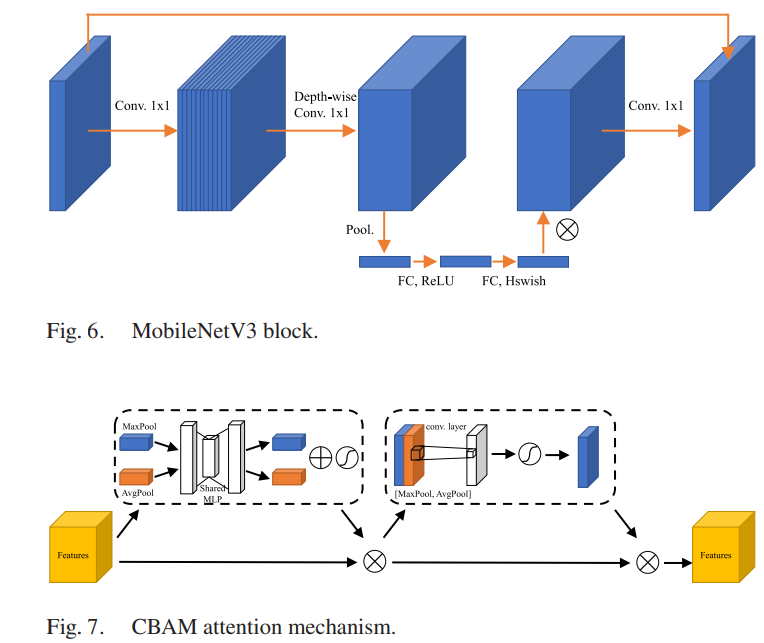

## Input

* consists of **VH-polarization** data and **DEM** data:
    * **DEM** data được chuẩn hóa, nội suy (**bilinear interpolation**) để cùng độ phân giải với **Sentinel-1**
    * Xếp chồng 2 dữ liệu thành 1 input: (VH biểu diễn bằng màu đỏ/xanh lá cây, DEM biểu diễn bằng xanh dương)  
    * *(?) nhưng làm thế nào để căn đúng tọa độ để chồng?*

* is limited by GPU, RAM, batchsize $\rightarrow$ Crop to **256x256 image** with **50 overlapping pixels** (tức là bao gồm 50 pixels giao với phần ảnh bên cạnh theo cả chiều ngang, chiều dọc, đảm bảo không có vùng quan trọng nào bị bỏ sót)

## Output

1️⃣ Sau khi sử dụng **Sigmoid Activation** đưa giá trị về khoảng [0,1], **U-Net** phân đoạn ảnh thành 2 lớp (land/sea)  
2️⃣ Phát hiện đường bờ biển bằng **Sobel Edge Detectioni**  
3️⃣ Ghép các **subimage** thành ảnh lớn  
4️⃣ Xử lý hậu kỳ: **Morphological Processing**
* **Closing & Hole Filling**: Kết nối các phần đường bờ bị gián đoạn
* **Thinning Operation**: Làm mỏng đường bờ nhưng vẫn giữ tính liên tục
* **Spurring Operation**: Loại bỏ các nhánh dư thừa của đường bờ



## Evaluation

* **Absolute distance**:
$$ d(i) = |P_{shoreline}(i) - R_{shoreline}(i) |$$

trong đó:
* $P_{shoreline}(i)$: predict result
* $R_{shoreline}(i)$: corresponding point in the reference shoreline

* **Mean**:
$$ Mean_d = \frac{1}{N_p} \sum_{i=1}^{N_p} d(i) $$

* **RMSE**:
$$ RMSE_d = \sqrt{\frac{1}{N_p}\sum_{i=1}^{N_p} d^2(i)} $$

trong đó: $N_p$ là tổng pixel trong dự đoán shoreline

* <font size="5">Cách tìm **corresponding point** của **predict point** </font>


*Phép giãn nở hình thái (dilate)*:

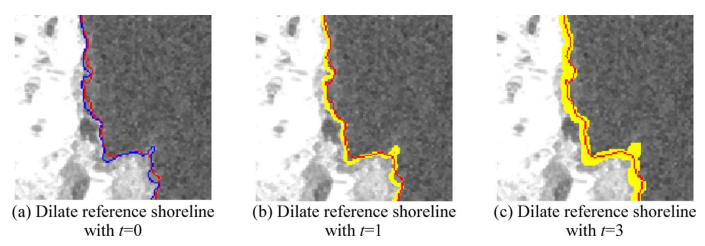

$\rightarrow$ giãn nở từ <span style="color: blue;">**đường shoreline**</span> lên thêm t=1, 3pixel (theo cấu trúc đĩa) thành <span style="color: yellow;">**đường dilate**</span> 

* Số điểm trong:

$$ Int(t) = \text{No.of} (P_{shoreline} \cap R_{shoreline} (\text{with t pixel dilation}) )$$

* Xác suất điểm trong:

$$ Pr(t) = \frac{Int(t) - Int(t-1)}{N_p}  \text{ for } t = 1,..., M$$

trong đó:
* $Int(t) - Int(t-1)$ là số điểm lọt thêm vào trong **miền dilate** nếu như tăng t 
* $N_p$ là tổng số điểm shoreline dự đoán
* $M$ là giá trị $t$ lớn nhất mở rộng để **điểm detected** trở thành điểm trong của **dilate**

> Ý nghĩa công thức: Nếu như tăng $t$ lên thì tỷ lệ điểm lọt vào trong dilate là bao nhiêu (thể hiện sai số)

**$\rightarrow$ $t\text{Pr}(t)$: factor nhân với sai số. Mở rộng $t$ càng nhiều thì phạt sai số càng cao**

* 💡 Qua đó đổi công thức tính sai số thành:  


$$ Mean_d =  \sum_{i=1}^{M} t\text{Pr}(i) $$  
$$ RMSE_d = \sqrt{\sum_{i=1}^{M} t^2\text{Pr}(i)} $$

* **Hàm phân phối tích lũy** (CDF)

$$ \text{CDF}(t) = \frac{\text{Int(t)}}{N_p} $$

# Result

## Environment

* **VGA** RTX3080 16gb, i7-8700k

* SLS1: 4061 images
* SLS1 DEM: 3822 images
* 90% **train**, 10% **test**

* **batch size**: 16
* **epochs**: 600
* Adam **Optimizer**
* **Loss function**: Binary cross-entropy
* **Learning rate**: 0.0001

## Results

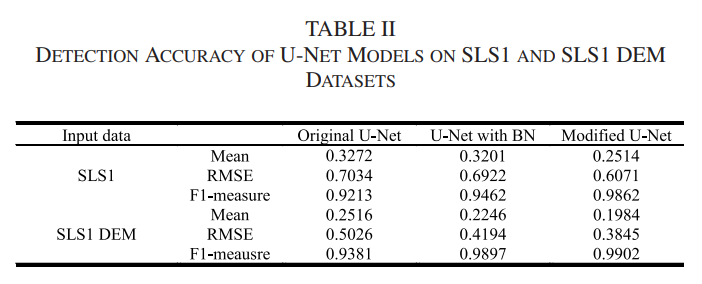

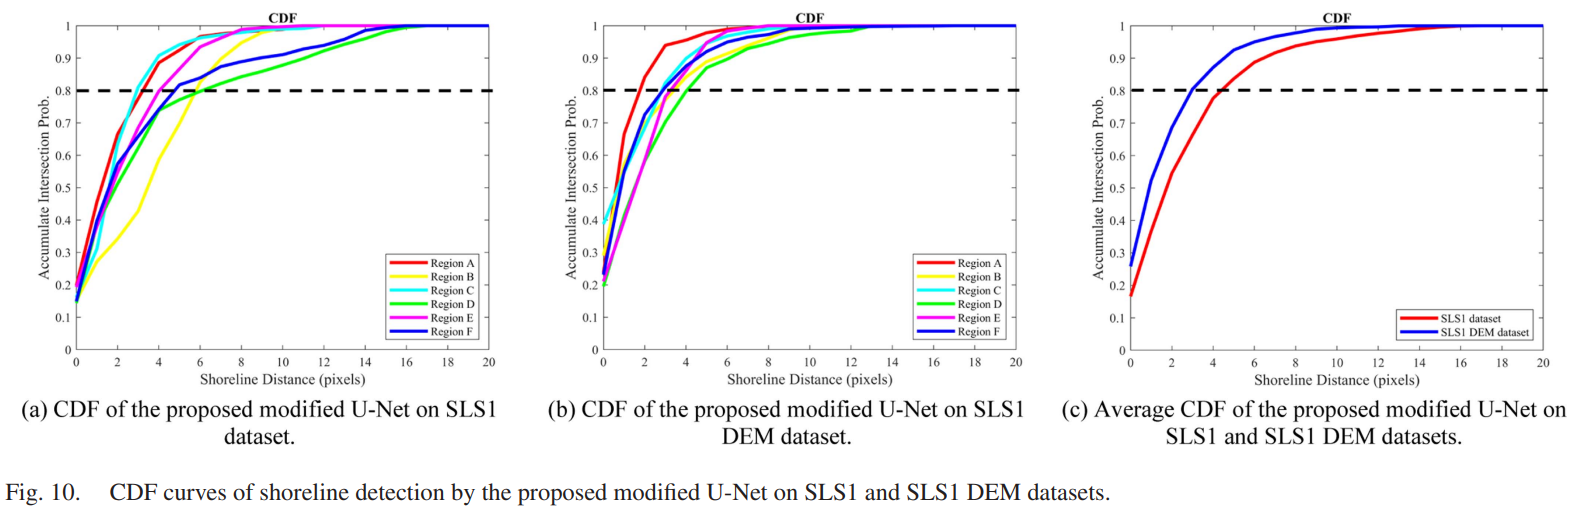

> **SLS1 + DEM** tốt hơn là **SLS1**

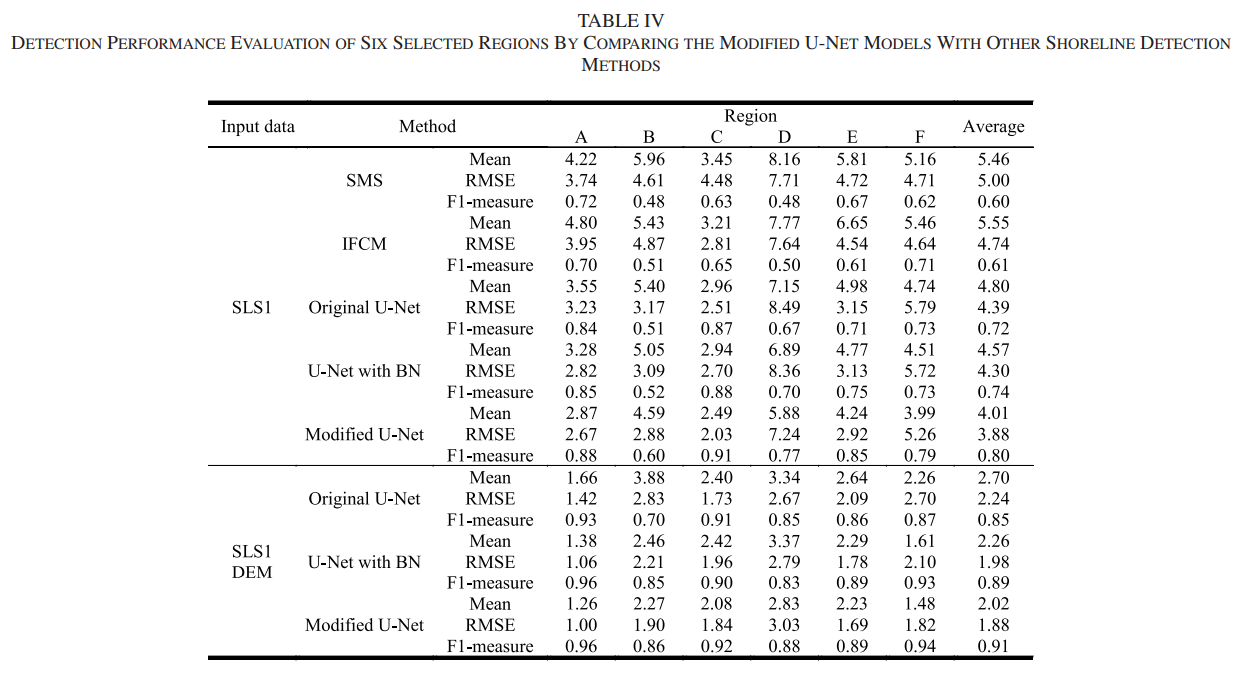

✅ Modified U-Net hoạt động tốt nhất trên cả hai tập dữ liệu (SLS1 & SLS1 DEM).  
✅ Kết hợp DEM giúp giảm sai số phát hiện đường bờ đến 50%.  
✅ Modified U-Net có độ chính xác cao hơn các phương pháp IFCM, SMS, và U-Net gốc.  
✅ Các khu vực có địa hình phức tạp (B, D) có độ sai lệch cao hơn, nhưng SLS1 DEM vẫn cải thiện đáng kể độ chính xác.